In [1]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
#from pred import Imageset
from torchvision.utils import save_image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!cp "/content/drive/My Drive/AUTOENCODER_AVANTARI/nithin.zip" "nithin.zip"

In [4]:
!unzip nithin.zip

Archive:  nithin.zip
   creating: dataset/
  inflating: dataset/3604.jpg        
  inflating: dataset/3487.jpg        
  inflating: dataset/2902.jpg        
  inflating: dataset/1484.jpg        
  inflating: dataset/1175.jpg        
  inflating: dataset/246.jpg         
  inflating: dataset/3618.jpg        
  inflating: dataset/3763.jpg        
  inflating: dataset/2436.jpg        
  inflating: dataset/3248.jpg        
  inflating: dataset/1662.jpg        
  inflating: dataset/4282.jpg        
  inflating: dataset/2351.jpg        
  inflating: dataset/4385.jpg        
  inflating: dataset/2380.jpg        
  inflating: dataset/4651.jpg        
  inflating: dataset/2830.jpg        
  inflating: dataset/1846.jpg        
  inflating: dataset/1807.jpg        
  inflating: dataset/1536.jpg        
  inflating: dataset/2977.jpg        
  inflating: dataset/120.jpg         
  inflating: dataset/1103.jpg        
  inflating: dataset/1985.jpg        
  inflating: dataset/1706.jpg        
  infla

fuction to read the images

In [5]:
def read_image_pil(path):
    img = Image.open(path)
    o_img = img.copy()
    #img = img.crop((64,0,448,384))
    img.thumbnail((255, 255), Image.ANTIALIAS)
    img = np.array(img)#[:32,:]
    # take rgb instead of rgba
    img = img[:,:,:3]
    return o_img,img 

reading images

In [6]:
np.random.seed(0)
images = []
for _, _, files in os.walk('/content/dataset'):
  for i,file in enumerate(files):
      if 'jpg' in file:
          print('loading',i,file)
          _,img = read_image_pil('/content/dataset'+'/'+file)
          #img = pil2tensor(img)
          images.append(img)

loading 0 3064.jpg
loading 1 2195.jpg
loading 2 4366.jpg
loading 3 1748.jpg
loading 4 3803.jpg
loading 5 3186.jpg
loading 6 2267.jpg
loading 7 1930.jpg
loading 8 3248.jpg
loading 9 4127.jpg
loading 10 3517.jpg
loading 11 2433.jpg
loading 12 2551.jpg
loading 13 1750.jpg
loading 14 882.jpg
loading 15 1034.jpg
loading 16 3249.jpg
loading 17 3846.jpg
loading 18 2403.jpg
loading 19 2155.jpg
loading 20 3489.jpg
loading 21 809.jpg
loading 22 4448.jpg
loading 23 929.jpg
loading 24 3787.jpg
loading 25 3422.jpg
loading 26 2110.jpg
loading 27 3344.jpg
loading 28 4633.jpg
loading 29 316.jpg
loading 30 4282.jpg
loading 31 782.jpg
loading 32 2132.jpg
loading 33 4149.jpg
loading 34 2736.jpg
loading 35 1966.jpg
loading 36 3931.jpg
loading 37 777.jpg
loading 38 2722.jpg
loading 39 3160.jpg
loading 40 3934.jpg
loading 41 1726.jpg
loading 42 3778.jpg
loading 43 1052.jpg
loading 44 2623.jpg
loading 45 2121.jpg
loading 46 2591.jpg
loading 47 3007.jpg
loading 48 416.jpg
loading 49 1474.jpg
loading 50 4242.j

In [ ]:
#plt.imshow(images[2])

Importing imageset class


In [7]:
from pred import Imageset

Transforming images to tensors with batch 7

In [8]:
transform_chain = transforms.Compose([
                        transforms.ToTensor()   
                        ])
data = Imageset(images, transform=transform_chain)
dataloader = torch.utils.data.DataLoader(data, batch_size=7,shuffle=False)
#loader = iter(dataloader)

Loading data
Done loading data
Length 4738


defining loss function for beta VAE

In [9]:
def loss_fn(recon_x, x, mu, logvar,beta=50.0):
    x = x.to(device)
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    KLD*=beta
    return BCE + KLD, BCE, KLD

importing VAE class

In [10]:
import vae
import torch.nn.functional as F

model for the VAE

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = vae.VAE(img_dim=255,image_channels=3,z_dim=128,device=device).to(device)

setting the optimizer

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

traning the VAE on data

In [13]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
filename = 'VAE_Beta50.pth'
epochs = 100
bs=32
train = True 
if train:
    epoch = 0
    while epoch < epochs:
        
        for idx in range(100):
            images = next(iter(dataloader))
            #images = images[0]
            recon_images,z, mu, logvar = model(images.to(device))
            loss, bce, kld = loss_fn(recon_images, images, mu, logvar, beta=10.0) # first beta 5
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                    epochs, loss.item()/bs, bce.item()/bs, kld.item()/bs)
        epoch+=1
        print(to_print)
        

    torch.save(model.state_dict(),  filename)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/100] Loss: 26594.541 26593.635 0.906
Epoch[2/100] Loss: 24824.582 24820.738 3.845
Epoch[3/100] Loss: 24282.516 24278.199 4.316
Epoch[4/100] Loss: 24154.430 24150.400 4.029
Epoch[5/100] Loss: 24119.021 24115.328 3.693
Epoch[6/100] Loss: 24069.596 24066.270 3.326
Epoch[7/100] Loss: 24055.195 24052.074 3.120
Epoch[8/100] Loss: 24041.012 24038.176 2.837
Epoch[9/100] Loss: 24022.352 24019.578 2.773
Epoch[10/100] Loss: 24019.215 24016.562 2.652
Epoch[11/100] Loss: 24014.506 24012.035 2.470
Epoch[12/100] Loss: 24009.309 24007.074 2.234
Epoch[13/100] Loss: 23989.156 23986.949 2.207
Epoch[14/100] Loss: 23992.346 23990.262 2.084
Epoch[15/100] Loss: 23991.195 23989.170 2.025
Epoch[16/100] Loss: 23981.094 23979.168 1.927
Epoch[17/100] Loss: 24004.383 24002.396 1.986
Epoch[18/100] Loss: 23970.541 23968.660 1.881
Epoch[19/100] Loss: 23968.004 23966.227 1.778
Epoch[20/100] Loss: 23967.428 23965.699 1.728
Epoch[21/100] Loss: 23964.674 23962.996 1.677
Epoch[22/100] Loss: 23963.830 23962.148 1.6

function for combining the actual image and reconstruted image

In [14]:
def compare(x):
    x=x.to(device)
    recon_x,z, _, _ = model(x)
    return torch.cat([x, recon_x])

visualizing the reconstructed image

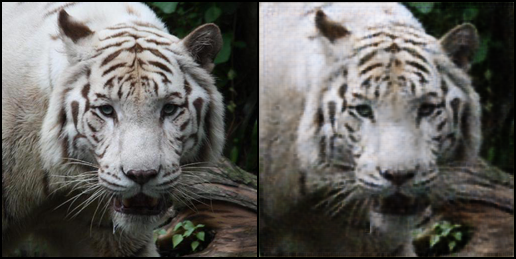

In [16]:
from IPython.display import Image
from IPython.core.display import Image, display
fixed_x = next(iter(dataloader))[1:2]
compare_x = compare(fixed_x)
save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png'))